In [36]:
from math import ceil
from itertools import combinations, product

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import scipy.signal


np.set_printoptions(precision=2, linewidth=200)

In [2]:
# Set seed for reproducibility
np.random.seed(0)

# Create a random collection of interconnected microgrids
N_grids = 5
min_generators_per_grid = 1
max_generators_per_grid = 5

generator_inertia_avg = 10.
generator_inertia_std = 4.
generator_inertia_std_within_grid = 2.

intergrid_susceptance_min = 0.1
intergrid_susceptance_max = 3.0
intragrid_susceptance_avg = 50.0
susceptance_std = 3

generator_damping = 2

# Choose how many generators are in each grid
generators_per_grid = np.random.randint(min_generators_per_grid, max_generators_per_grid, N_grids)

# Choose the average inertia of each grid and the inertia of the generators in each grid
grid_avg_inertias = np.random.normal(loc=generator_inertia_avg, scale=generator_inertia_std, size=(N_grids))
generator_inertias = [
    np.random.normal(loc=avg_inertia, scale=generator_inertia_std_within_grid, size=(n_generators))
    for n_generators, avg_inertia in zip(generators_per_grid, grid_avg_inertias)
]

# Choose the susceptance between grids (we'll only use the upper right triangle of this matrix)
intergrid_susceptance = {
    (i, j): np.random.uniform(intergrid_susceptance_min, intergrid_susceptance_max)
    for i, j in combinations(range(N_grids), 2)
    if i != j
}
intergrid_susceptance[("Reference", 0)] = np.random.uniform(intergrid_susceptance_min, intergrid_susceptance_max)

# Choose the susceptance between each generator and its grid
generator_susceptance = [
    np.random.normal(loc=intragrid_susceptance_avg, scale=susceptance_std, size=(n_generators))
    for n_generators in generators_per_grid
]

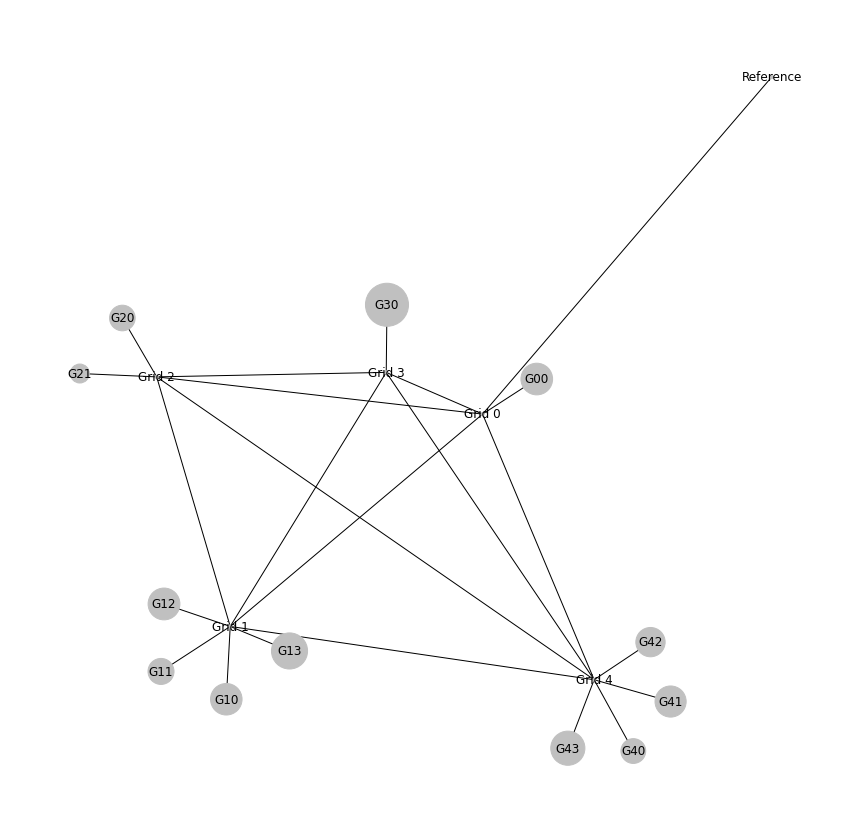

In [3]:
# Visualize the network
G = nx.Graph()

# Add buses for all of the grids
for i in range(N_grids):
    G.add_node(f"Grid {i}", inertia=0.1)

G.add_node(f"Reference", inertia=0.1)

# Add edges with the appropriate weight between grids
for connection, susceptance in intergrid_susceptance.items():
    node_a = f"Grid {connection[0]}" if isinstance(connection[0], int) else "Reference"
    node_b = f"Grid {connection[1]}"
    G.add_edge(node_a, node_b, susceptance=susceptance, reactance=1/susceptance)
    
# Add the generators in each grid
for i in range(N_grids):
    grid_name = f"Grid {i}"
    for j in range(generators_per_grid[i]):
        node_name = f"G{i}{j}"
        susceptance = generator_susceptance[i][j]
        G.add_node(node_name, inertia=generator_inertias[i][j])
        G.add_edge(node_name, grid_name, susceptance=susceptance, reactance=1/susceptance)
        

# Plot with a spring layout
plt.subplots(figsize=(15, 15))
pos = nx.spring_layout(G, scale=10, seed=0, weight="susceptance")
inertias = [100 * n[1]["inertia"] for n in G.nodes.data()]
nx.draw(G, pos=pos, node_size=inertias, with_labels=True, node_color="silver")

In [62]:
# Get the susceptance matrix by computing the resistance distance between each generator
generator_names = [
    f"G{i}{j}"
    for i in range(N_grids)
    for j in range(generators_per_grid[i])
]
N_G = len(generator_names)
susceptance_matrix = np.zeros((N_G, N_G))
for i, Gi in enumerate(generator_names):
    for j, Gj in enumerate(generator_names):
        # There are two cases. Mutual susceptance is easy, since it's the reciprocal of
        # the reactance distance between two nodes
        if i != j:
            susceptance_matrix[i, j] = 1 / nx.resistance_distance(G, Gi, Gj, weight="reactance")

# The self-susceptance is calculated from the sum of other susceptances minus the susceptance to the reference
# TODO: account for loads?
susceptance_to_reference = np.zeros((N_G, 1))
for i, Gi in enumerate(generator_names):
    susceptance_to_reference[i, 0] = 1 / nx.resistance_distance(G, Gi, "Reference", weight="reactance")
    susceptance_matrix[i, i] = -susceptance_matrix[i, :].sum() - susceptance_to_reference[i, 0]

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [63]:
# Define inertia and damping matrices
inertia_matrix = np.diag([G.nodes[generator_name]["inertia"] for generator_name in generator_names])
damping_matrix = np.diag([generator_damping] * N_G)
agc_matrix = np.diag([0.1] * N_G)  # TODO(hack) maybe not used

# Now let's define the second order dynamics M x_dd + C x_d + K x = Bu
M = inertia_matrix
C = damping_matrix
K = -susceptance_matrix
B = susceptance_to_reference

# For convenience when simulating, invert the mass matrix
Minv = np.linalg.inv(M)

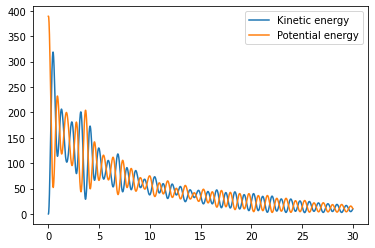

In [64]:
# Now we can simulate the unforced system response from a random initial state
np.random.seed(0)
x0 = np.random.normal(size=(N_G, 1))

T_sim = 30.0
dt = 0.01
xs = np.zeros((N_G, int(T_sim // dt)))
dx_dts = np.zeros((N_G, int(T_sim // dt)))
xs[:, 0] = x0.squeeze()

for i in range(1, int(T_sim // dt)):
    dx_dts[:, i] = dx_dts[:, i - 1] + dt * Minv @ (-C @ dx_dts[:, i - 1] - K @ xs[:, i - 1])
    xs[:, i] = xs[:, i - 1] + dt * dx_dts[:, i - 1]
    
# Kinetic and potential energy
kinetic_energy = np.zeros(int(T_sim // dt))
potential_energy = np.zeros(int(T_sim // dt))
for i in range(0, int(T_sim // dt)):
    kinetic_energy[i] = 0.5 * (dx_dts[:, i].T @ M @ dx_dts[:, i])
    potential_energy[i] = 0.5 * (xs[:, i].T @ K @ xs[:, i])
    
t_range = np.arange(0, T_sim - dt, dt)
i = 0  # which generator to plot
plt.plot(t_range, kinetic_energy, label="Kinetic energy")
plt.plot(t_range, potential_energy, label=f"Potential energy")
plt.legend()

In [7]:
# Currently, we don't have much intuition about which parts of the state are important for
# the behavior of the system over various time scales. Let's try to gain more insight with
# a modal transformation

# Solve the generalized eigenvalue problem \omega^2 M x = K x
w, V = scipy.linalg.eigh(K, M)
w = np.sqrt(w)

# Normalize the modes by the mass matrix, going column by column
for i in range(V.shape[1]):
    V[:, i] = V[:, i] / (V[:, i].T @ M @ V[:, i]) ** 0.5

# This gives new modal mass, damping, and stiffness matrices, which mostly decouple the modal DoFs
Mbar = V.T @ M @ V
Cbar = V.T @ C @ V
Kbar = V.T @ K @ V
Bbar = V.T @ B
# There is still some coupling through the damping matrix, but this still gives us some ability for analysis

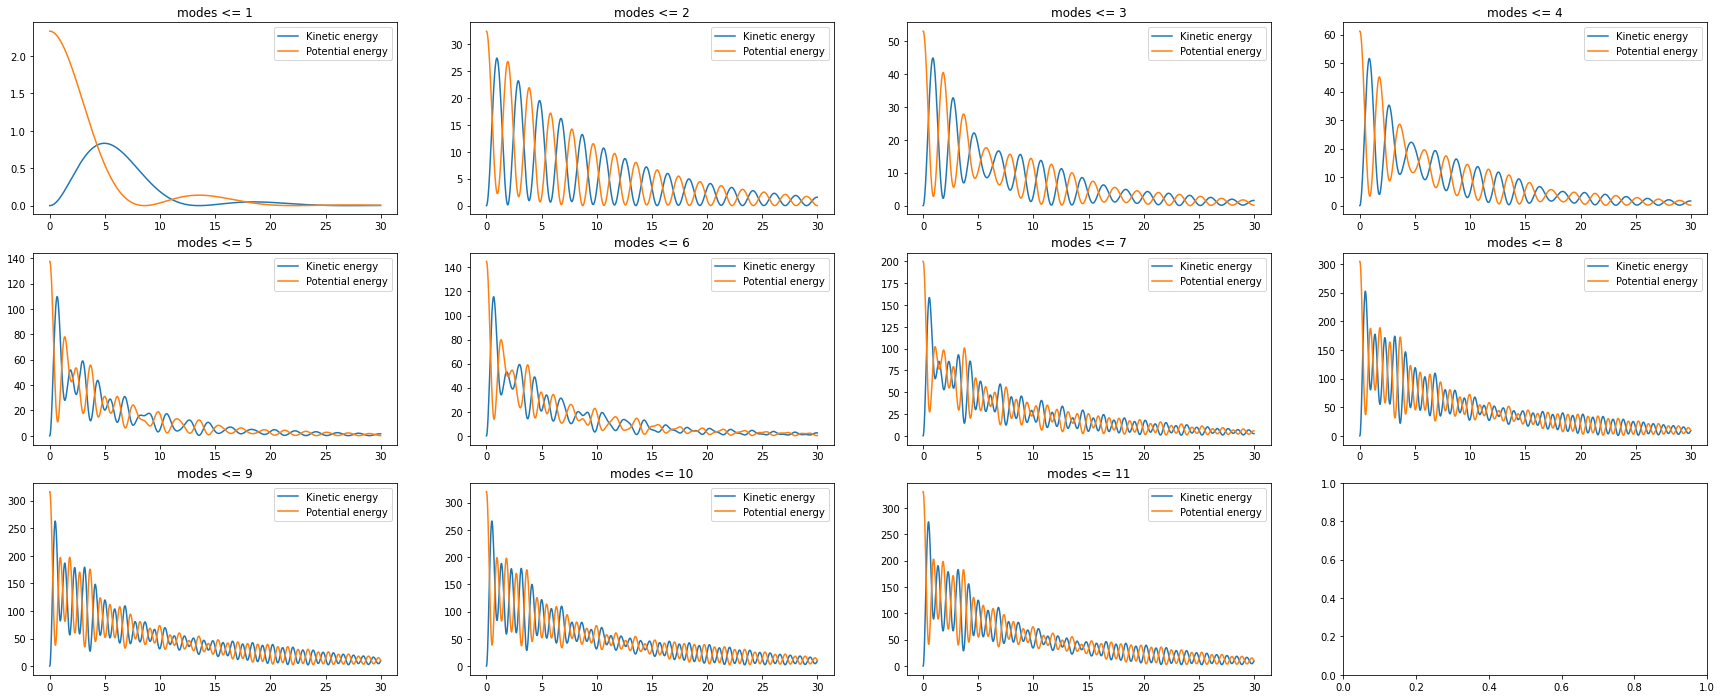

In [19]:
# Let's compare the behavior of a "truncated" system with that of the original,
# by only considering the first r modes

orders = range(1, N_G)
n_rows = 3
_, axs = plt.subplots(n_rows, ceil(len(orders) / n_rows), figsize=(30, 12))
axs = axs.ravel()
energy = np.zeros(N_G - 1)

for idx, (ax, r) in enumerate(zip(axs, orders)):
    Mbar_r = Mbar[:r, :r]
    Mbar_inv_r = np.linalg.inv(Mbar_r)
    Cbar_r = Cbar[:r, :r]
    Kbar_r = Kbar[:r, :r]

    V_r = V[:, :r]
    Vinv_r = np.linalg.inv(V)[:r, :]

    eta0 = Vinv_r @ x0

    T_sim = 30.0
    dt = 0.01
    etas = np.zeros((r, int(T_sim // dt)))
    deta_dts = np.zeros((r, int(T_sim // dt)))
    etas[:, 0] = eta0.squeeze()

    for i in range(1, int(T_sim // dt)):
        deta_dts[:, i] = deta_dts[:, i - 1] + dt * Mbar_inv_r @ (-Cbar_r @ deta_dts[:, i - 1] - Kbar_r @ etas[:, i - 1])
        etas[:, i] = etas[:, i - 1] + dt * deta_dts[:, i - 1]

    # Partially reconstruct states from modes
    xs = V_r @ etas
    dx_dts = V_r @ deta_dts

    # Kinetic and potential energy
    kinetic_energy = np.zeros(int(T_sim // dt))
    potential_energy = np.zeros(int(T_sim // dt))
    for i in range(0, int(T_sim // dt)):
        kinetic_energy[i] = 0.5 * (dx_dts[:, i].T @ M @ dx_dts[:, i])
        potential_energy[i] = 0.5 * (xs[:, i].T @ K @ xs[:, i])
        energy[idx] += dt * (kinetic_energy[i] + potential_energy[i]) / T_sim

    t_range = np.arange(0, T_sim - dt, dt)
    i = 0  # which generator to plot
    ax.plot(t_range, kinetic_energy, label="Kinetic energy")
    ax.plot(t_range, potential_energy, label=f"Potential energy")
    ax.set_title(f"modes <= {r}")
    ax.legend()

Text(0, 0.5, '% of average total energy')

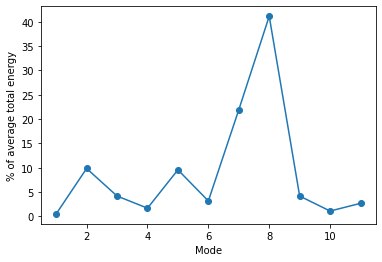

In [23]:
# We can also plot how much total "energy" we're capturing in each state
# (not quite energy, but integral of total energy, still informative)
modal_energy_content = np.diff(energy / energy[-1], prepend=0)
plt.plot(orders, 100 * modal_energy_content, "o-")
plt.xlabel("Mode")
plt.ylabel("% of average total energy")

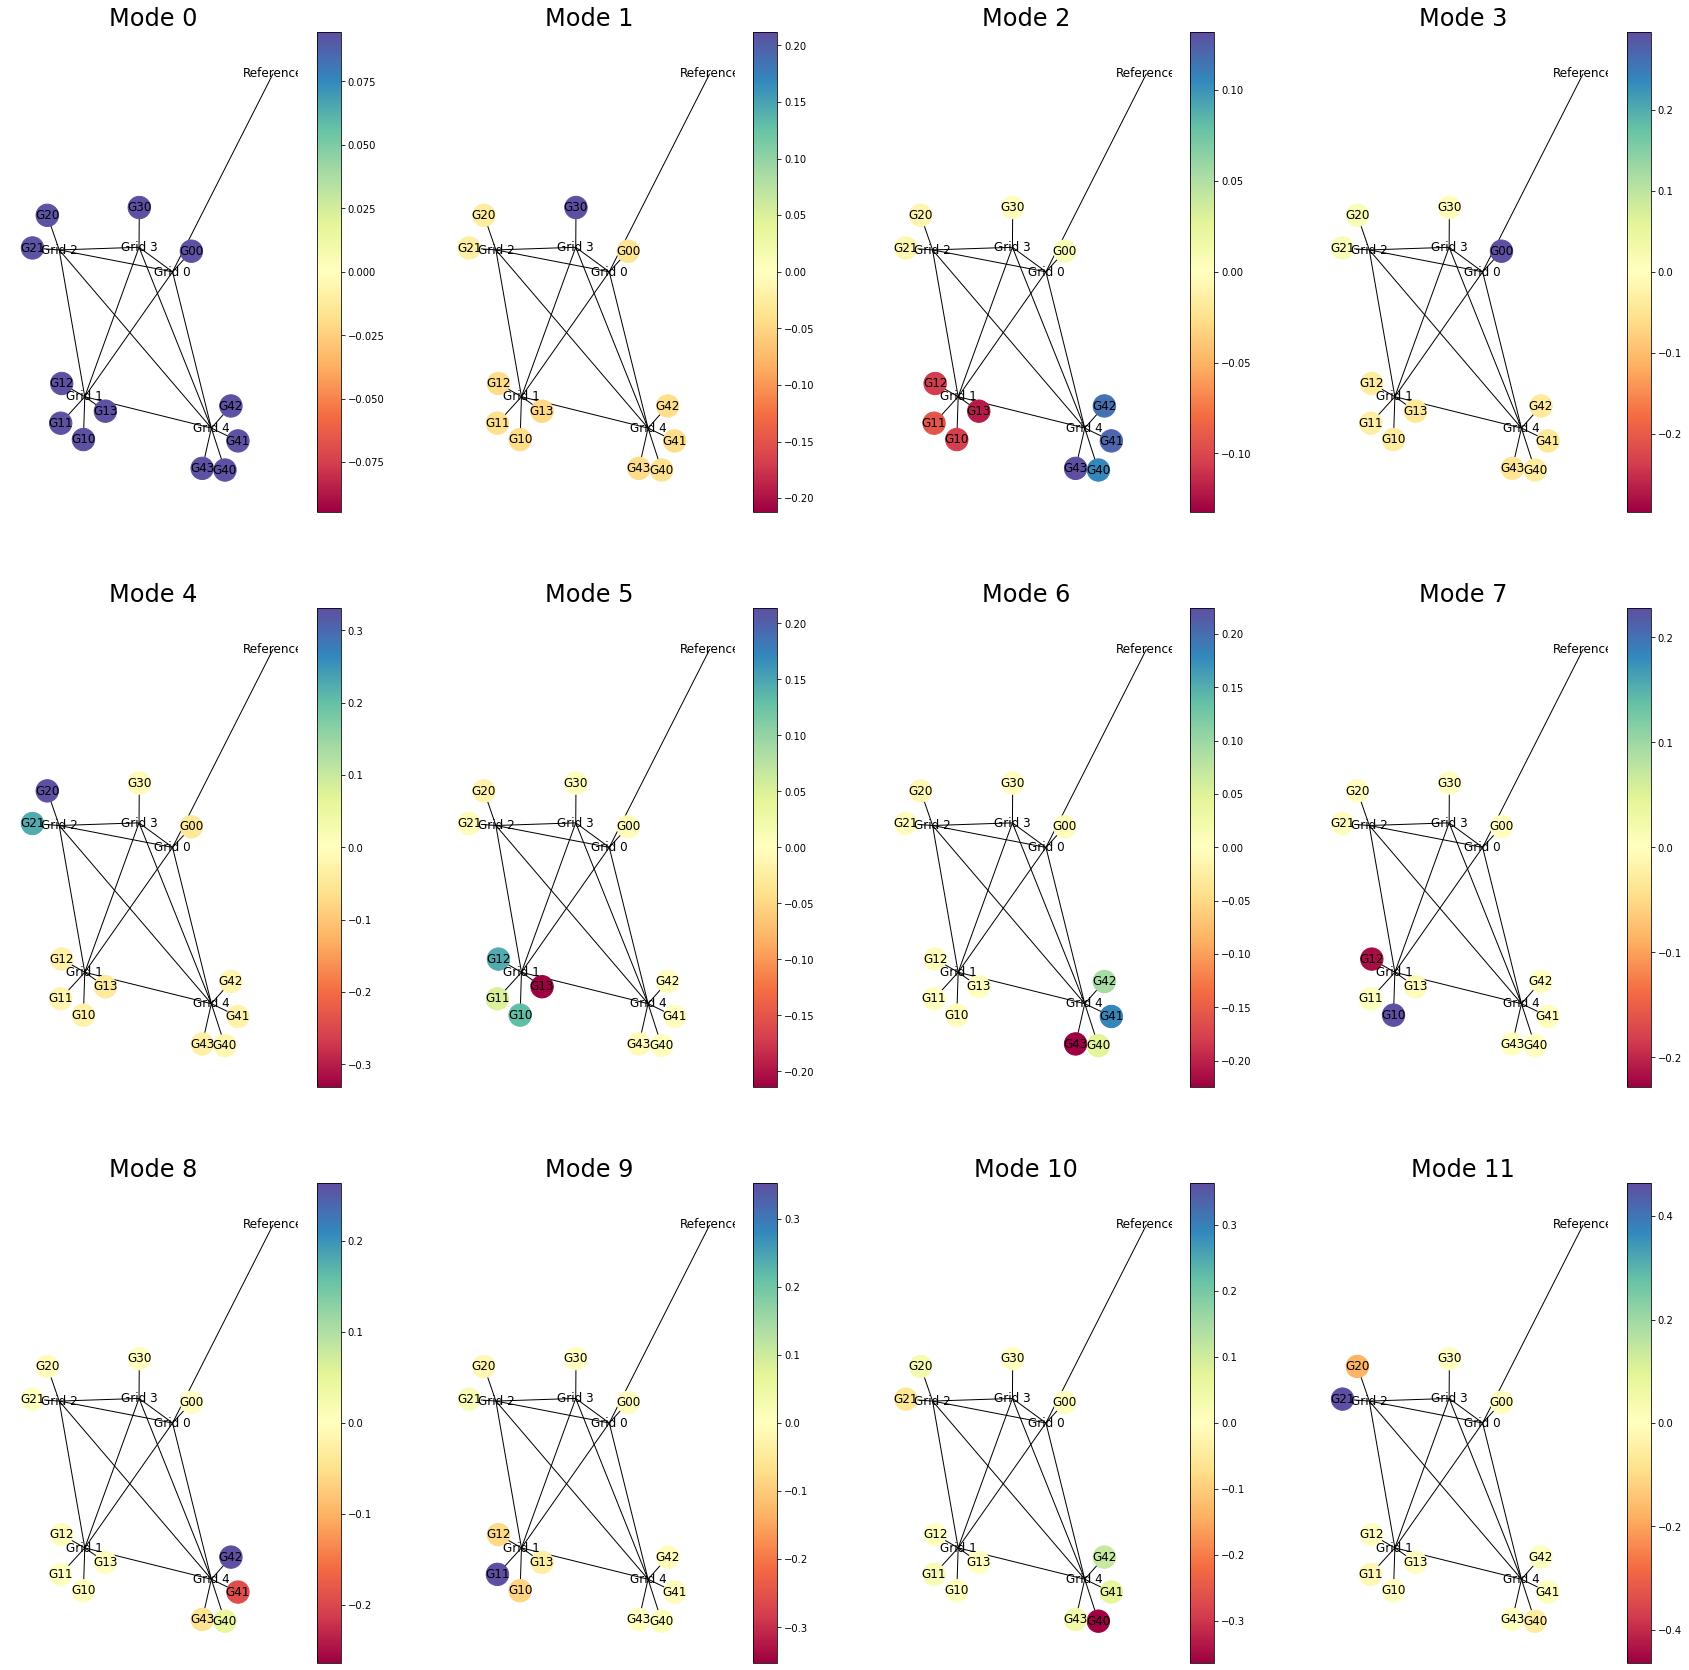

In [26]:
# Now let's visualize the network again to highlight the modes
modes = range(N_G)
n_rows = 3
fig, axs = plt.subplots(n_rows, ceil(len(modes) / n_rows), figsize=(30, 30))
axs = axs.ravel()

for ax, mode in zip(axs, modes):
    # Add modal contributions to each node in the grid
    for i in range(N_grids):
        G.nodes[f"Grid {i}"]["contribution"] = 0.0  # no contribution from grid buses
    G.nodes["Reference"]["contribution"] = 0.0  # no contribution from reference bus

    for i, Gi in enumerate(generator_names):
        G.nodes[Gi]["contribution"] = V[i, mode]        

    # Plot with a spring layout, coloring nodes to show contribution to the mode
    pos = nx.spring_layout(G, scale=10, seed=0, weight="susceptance")
    contributions = [G.nodes[n]["contribution"] for n in G.nodes]
    sizes = [500 if "Grid" not in n and "Reference" not in n else 0 for n in G.nodes]
    vmin = min(contributions)
    vmax = max(max(contributions), -vmin)
    vmin = min(vmin, -vmax)
    cmap="Spectral"
    nx.draw(
        G,
        pos=pos,
        node_size=sizes,
        with_labels=True,
        node_color=contributions,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        ax=ax,
    )

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    ax.set_title(f"Mode {mode}", fontsize=24);

Text(0, 0.5, 'Inertia')

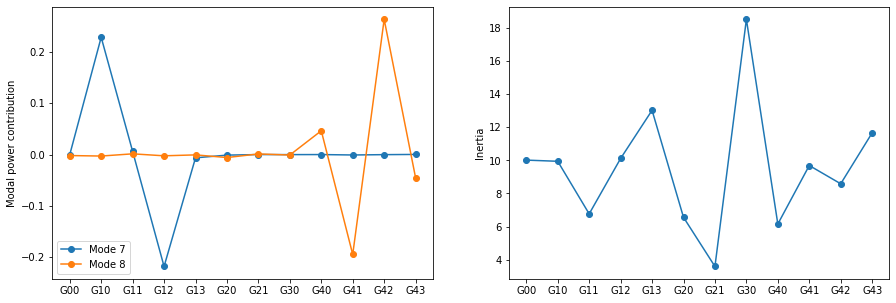

In [28]:
modes = [7, 8]
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for mode in modes:
    plt.plot(generator_names, V[:, mode], "o-", label=f"Mode {mode}")
plt.ylabel("Modal power contribution")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(generator_names, np.diag(M), "o-")
plt.ylabel("Inertia")

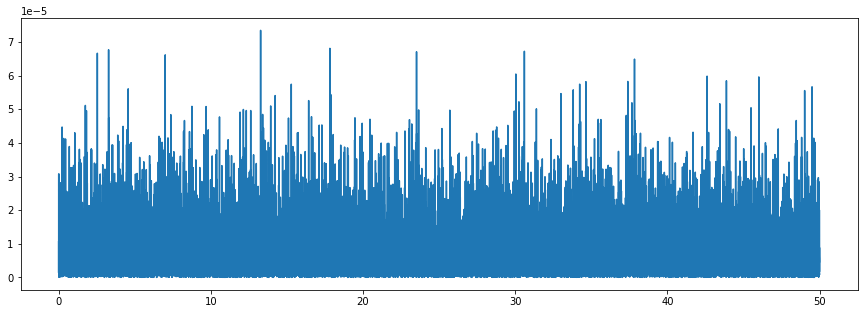

In [192]:
# What is the bode plot of this network? Let's excite it with some random noise
f_min = 0.0  # Hz
f_max = 4 * np.max(w) / (2 * np.pi)
T_test = 500
dt = 1e-2
t = np.arange(0, T_test, dt)
u = np.random.normal(size=(t.shape[0],))  # random variation at the reference

def bandpass(s, f_min, f_max, dt):
    s_fft = np.fft.fft(s)
    f = np.fft.fftfreq(s.shape[0], d=dt)
    s_fft_keep = np.where(np.logical_and(np.abs(f) >= f_min, np.abs(f) <= f_max), s_fft, 0)
    power_removed = np.sum(np.absolute(s_fft_keep)) / np.sum(np.absolute(s_fft))
    return np.fft.ifft(s_fft_keep / power_removed).real

band_limited_noise = u  # bandpass(u, f_min, f_max, dt)

# Plot the fft power spectrum
u_fft = np.fft.fft(scipy.signal.windows.hamming(t.shape[0]) * band_limited_noise)
freq = np.fft.fftfreq(t.shape[0], d=dt)
N = int(u_fft.shape[0])

plt.figure(figsize=(15, 5))
plt.plot(freq[:N // 2], np.absolute(u_fft[:N // 2] / N) ** 2)

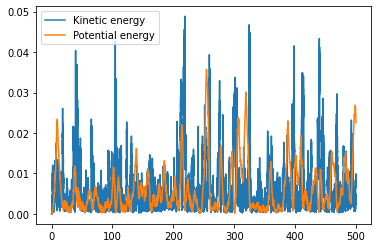

In [193]:
xs = np.zeros((N_G, band_limited_noise.shape[0]))
dx_dts = np.zeros((N_G, band_limited_noise.shape[0]))

for i in range(1, band_limited_noise.shape[0]):
    dx_dts[:, i] = dx_dts[:, i - 1] + dt * Minv @ (-C @ dx_dts[:, i - 1] - K @ xs[:, i - 1] + B @ band_limited_noise[i].reshape(-1))
    xs[:, i] = xs[:, i - 1] + dt * dx_dts[:, i - 1]
    
# Kinetic and potential energy
kinetic_energy = np.zeros(int(T_test // dt))
potential_energy = np.zeros(int(T_test // dt))
for i in range(0, int(T_test // dt)):
    kinetic_energy[i] = 0.5 * (dx_dts[:, i].T @ M @ dx_dts[:, i])
    potential_energy[i] = 0.5 * (xs[:, i].T @ K @ xs[:, i])
    
plt.plot(t[:-1], kinetic_energy, label="Kinetic energy")
plt.plot(t[:-1], potential_energy, label=f"Potential energy")
plt.legend()

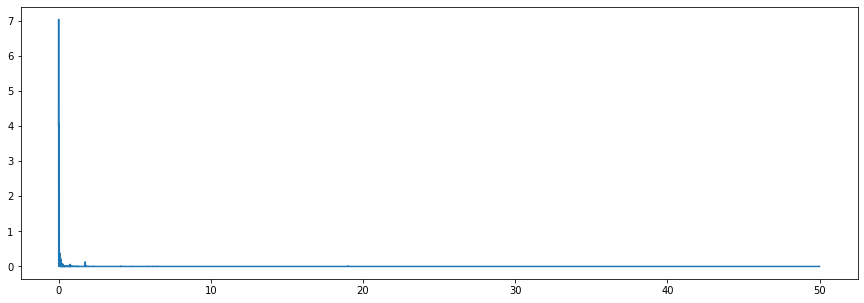

In [201]:
total_energy = kinetic_energy + potential_energy
energy_fft = np.fft.fft(scipy.signal.windows.hamming(total_energy.shape[0]) * total_energy)
freq = np.fft.fftfreq(total_energy.shape[0], d=dt)
N = int(energy_fft.shape[0])

plt.figure(figsize=(15, 5))
plt.plot(freq[:N // 2], np.absolute(energy_fft[:N // 2] / N) ** 2 / np.absolute(u_fft[:N // 2] / N) ** 2)
# plt.plot(t[:-1], total_energy)